# Beoordeling Tijdreeksmodellen

Een veelgestelde vraag is hoe je een geoptimaliseerd tijdreeksmodel moet beoordelen. In dit notebook worden methodes voor modelbeoordeling gepresenteerd en geïllustreerd met voorbeelden uit de praktijk. 

**Inhoudsopgave**

- [Introductie](#Introductie)
- [Visuele beoordeling](#Visuele-beoordeling)
- [Fit statistieken](#Fit-statistieken)
- [Cross validatie](#Cross-validatie)
- [Modelonzekerheid](#Modelonzekerheid)
- [Correlatie modelparameters](#Correlatie-modelparameters)
- [Hydrologische beoordeling](#Hydrologische-beoordeling)
- [Discussie](#Discussie)
- [Referenties](#Referenties)

## Introductie

Voor het gebruiken of afkeuren van een tijdreeksmodel is het belangrijk om vast te stellen wat het doel van het tijdreeksmodel is. Op basis van dit doel kunnen de criteria worden gesteld voor het beoordelen van het model. Dit notebook geeft een overzicht van veel voorkomende methodes om tijdreeksmodellen te beoordelen. Per onderwerp wordt de belangrijkste achtergrondinformatie gepresenteerd, maar het is zeker geen volledig overzicht van al het onderzoek en werk wat op dat vlak is gedaan. Voor de lezers die daarin geïnteresseerd zijn hebben we referenties opgenomen waarmee men dieper in het onderwerp kan duiken.

### Algemeen stappenplan

We presenteren hier een aantal stappen die vaak worden toegepast om tijdreeksmodellen te beoordelen. Er is niet zoiets als een definitief stappenplan voor modelbeoordeling, dus er zijn ongetwijfeld methodes voor modelbeoordeling die niet in dit notebook zijn opgenomen. Ook de volgorde van de stappen staat zeker niet vast, maar is logisch gestructureerd naar inzicht van de auteurs. 

- **Visuele beoordeling:** De eerste stap is vaak een visuele beoordeling van het tijdreeksmodel. Het gedrag van het model wordt visueel geinspecteerd waarbij veel waardevolle inzichten worden verkregen over het model. Het nadeel van deze stap is dat deze relatief veel tijd kost. 
- **Fit-statistieken:** De tweede stap is een beschouwing van de overeenkomst tussen model en metingen (de fit) op basis van fit-statistieken. Het voordeel van deze stap is dat er een objectieve maat wordt gegeven die iets zegt over overeenkomst tussen model en metingen. Het nadeel van deze stap is dat er veel waardevolle informatie verloren gaat bij het terugbrengen van de prestatie van het model tot enkele getallen.
- **Testen model:** De derde stap is het testen van het model (dit wordt ook vaak validatie genoemd), door bijvoorbeeld een simulatie te doen met het model op een periode met metingen die niet is gebruikt in de kalibratie. Hiermee wordt het model getest op informatie die niet is gebruikt in het optimaliseren van de modelparameters.
- **Modelonzekerheid:** De vierde stap is het beschouwen van de modelonzekerheid. Daarbij stellen we eigenlijk de vraag: kunnen de modelparameters goed bepaald worden? Voordat we die onzekerheid kunnen beoordelen, moet het model aan enkele statistische eisen voldoen. Als het model niet aan die eisen voldoet, kunnen we de onzekerheid van de modelparameters niet goed inschatten, en dus niet gebruiken in onze beoordeling. Het model is dan nog wel bruikbaar; de parameters worden goed geschat, maar de onzekerheden dus niet. 
- **Parametercorrelaties:** De vijfde stap is het beoordelen van de correlaties tussen modelparameters. In deze stap wordt beschouwd of de effecten van verschillende parameters wel onderscheiden kunnen worden.
- **Hydrologische beoordeling:** De laatste stap die we hier presenteren is de hydrologische beoordeling waarbij de resultaten van de tijdreeksmodellen naast de hydrologische kennis over het systeem worden gelegd. Dit kan zowel op invididuele tijdreeksmodellen worden toegepast als ruimtelijk op de resultaten van meerdere tijdreeksmodellen. Hier wordt bijvoorbeeld de kennis over het hydrologische systeem gebruikt om de modellen te beoordelen, maar worden ook de resultaten van de modellen gebruikt om het hydrologisch inzicht in het systeem uit te breiden.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pastas as ps
import datetime as dt
from scipy.stats import norm, probplot

# stel de logger in om alleen foutmeldingen naar het scherm te printen
ps.set_log_level("ERROR")

# print de versies van belangrijke Python packages voor pastas
# ps.show_versions(numba=True)
%config InlineBackend.figure_format = 'svg'

In [2]:
# hulpfuncties en instellingen voor tabelweergave
cmap = plt.get_cmap("RdBu")
norma = mpl.colors.Normalize(vmin=-1.0, vmax=1.0)


def cbg(val):
    # functie voor kleuren achtergrond voor tabellen
    color = mpl.colors.rgb2hex(cmap(norma(val)))
    return f"background-color: {color}"


def ctxt(val):
    # functie voor weergeven witte of zwarte tekst in tabellen
    bg = cmap(norma(val))
    c = "White" if np.mean(bg[:3]) < 0.4 else "Black"
    return f"color: {c}"


def plot_results_ml(ml):
    # functie voor weergeven modelresultaten
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
    ml.plot(ax=ax1, legend=False)
    ax1.set_ylabel('stijghoogte [m NAP]')
    ax1.grid()
    handles, labels = ax1.get_legend_handles_labels()
    labels = ['Head', 'Simulation']
    ax1.legend(handles, labels, loc="upper left", ncol=2)
    ml.residuals().plot(ax=ax2, color="C1", label="residuals")
    ax2.axhline(0.0, linestyle="dashed", color="k", lw=1.5)
    ax2.set_ylabel('residuen [m]')
    ax2.grid()
    fig.tight_layout()

    return fig


def fit_stats_model(ml):
    # functie voor invullen tabel met fit statistieken
    stats = [
        "Mean absolute error (mae)",
        "Root mean squared error (rmse)",
        "Sum of the squares of the error (sse)",
        "Explained variance percentage (evp)",
        "R-squared (rsq)"
    ]

    df = pd.DataFrame(index=stats, columns=["waarde", "eenheid"])
    # fit statistics kunnen in pastas worden opgevraagd met:
    # `<model>.stats.<naam statische parameter>()`
    df.loc[stats[0], :] = ml.stats.mae(), "m"
    df.loc[stats[1], :] = ml.stats.rmse(), "m"
    df.loc[stats[2], :] = ml.stats.sse(), "m^2"
    df.loc[stats[3], :] = ml.stats.evp(), "%"
    df.loc[stats[4], :] = ml.stats.rsq(), "-"

    return df


def get_stats_train_test(ml, train_tmin, train_tmax,
                         test_tmin, test_tmax):
    # functie voor invullen tabel cross validatie
    sim = ml.simulate(tmin=train_tmin, tmax=train_tmax)
    obs = ml.oseries.series_original[train_tmin:str(int(train_tmax)-1)]

    stats = [
        "Mean absolute error (mae)",
        "Root mean squared error (rmse)",
        "Sum of squares of the error (sse)",
        "Explained variance percentage (evp)",
        "Nash-Sutcliffe model efficiency (nse)"
    ]

    df = pd.DataFrame(index=stats, columns=[
                      f"training: {train_tmin}-{train_tmax}",
                      f"test: {test_tmin}-{test_tmax}", "eenheid"])

    # statistieken periode 1985 - 2000
    df.loc[stats[0], f"training: {train_tmin}-{train_tmax}"] = \
        ps.stats.mae(obs=obs, sim=sim)
    df.loc[stats[1], f"training: {train_tmin}-{train_tmax}"] = \
        ps.stats.rmse(obs=obs, sim=sim)
    df.loc[stats[2], f"training: {train_tmin}-{train_tmax}"] = \
        ps.stats.sse(obs=obs, sim=sim)
    df.loc[stats[3],
           f"training: {train_tmin}-{train_tmax}"] = \
        ps.stats.evp(obs=obs, sim=sim)
    df.loc[stats[4], f"training: {train_tmin}-{train_tmax}"] = \
        ps.stats.nse(obs=obs, sim=sim)

    # statistieken periode 2000 - 2015
    sim = ml.simulate(tmin=test_tmin, tmax=test_tmax)
    obs = ml.oseries.series_original[test_tmin:str(int(test_tmax)-1)]
    df.loc[stats[0], f"test: {test_tmin}-{test_tmax}"] = \
        ps.stats.mae(obs=obs, sim=sim)
    df.loc[stats[1], f"test: {test_tmin}-{test_tmax}"] = \
        ps.stats.rmse(obs=obs, sim=sim)
    df.loc[stats[2], f"test: {test_tmin}-{test_tmax}"] = \
        ps.stats.sse(obs=obs, sim=sim)
    df.loc[stats[3], f"test: {test_tmin}-{test_tmax}"] = \
        ps.stats.evp(obs=obs, sim=sim)
    df.loc[stats[4], f"test: {test_tmin}-{test_tmax}"] = \
        ps.stats.nse(obs=obs, sim=sim)

    df.loc[:, "eenheid"] = ["m", "m", "m^2", "%", "-"]

    return df

In [3]:
# set options to display DataFrames in PDF
pd.set_option("display.latex.repr", True)
pd.set_option("display.latex.longtable", True)


def _repr_latex_(self):
    latex = """\\begin{center}
    {%s}
    \\end{center}""" % self.to_latex(float_format="{:0.3f}".format, bold_rows=True)
    return latex


pd.DataFrame._repr_latex_ = _repr_latex_  # monkey patch pandas DataFrame

In [28]:
# %%html
# <style>
# table {float: left}
# </style>

## Visuele beoordeling

Een eenvoudige manier om een tijdreeksmodel te beoordelen is het visualiseren van de resultaten. De modelsimulatie wordt samen met de metingen in een grafiek weergegeven. Vaak worden de modelresiduën ook gepresenteerd. Aan de hand van beide grafieken kan visueel beoordeeld worden of de simulatie door de metingen loopt, of de metingen helemaal niet goed benadert. Ook kan beoordeeld worden in welke periodes het model het goed doet, en in welke periodes niet. Is het model bijvoorbeeld goed in staat om de pieken en dalen te simuleren?

<hr>

#### Voorbeeld visuele beoordeling 1

Als voorbeeld van een visuele beoordeling is een tijdreeksmodel geselecteerd waarin de grondwaterstand wordt verklaard aan de hand van neerslag en verdamping. De modelsimulatie (blauwe lijn) en de metingen (zwarte punten) staan in de bovenste grafiek. De residuen (oranje lijn) zijn in de onderste grafiek weergegeven. 

In de figuur is te zien dat de simulatie en de metingen goed overeen komen. In de residuen is te zien dat het verschil tussen model en meting het grootste is bij de extremen: de dalen in de zomer en de pieken in de winter. De residuen laten echter geen duidelijk patroon zien en zijn netjes verdeeld om de nul-lijn, dus er is geen sprake van een structurele fout in het model. 

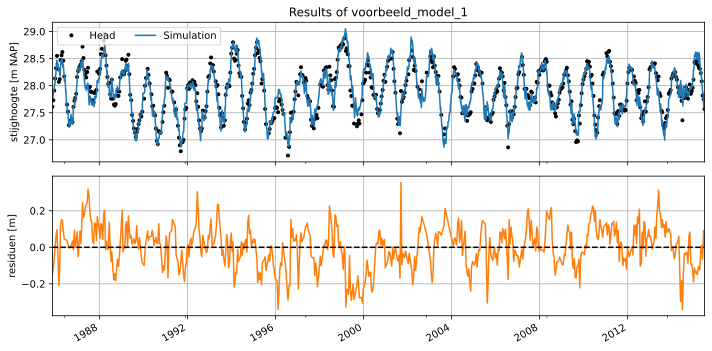

In [5]:
# inladen voorbeeld model
ml1 = ps.io.load("./data/basic_model.pas")

# plot resultaten
f1 = plot_results_ml(ml1)

<hr>

#### Voorbeeld visuele beoordeling 2

Onderstaand voorbeeld laat een tijdreeksmodel zien waar de modelsimulatie (blauwe lijn) slecht overeenkomt met de metingen (zwarte punten). De simulatie wijkt tot wel 2 meter af van de gemeten grondwaterstand. Met dit model is het niet mogelijk om betrouwbare simulaties te maken.

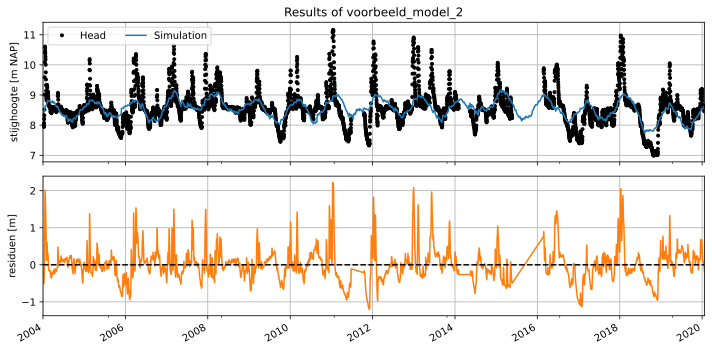

In [6]:
# model uit voorbeeld notebook
ml_visueel2 = ps.io.load("./data/vb_visueel2.pas")
ml_visueel2.solve(tmin="2004", report=False)

# plot resultaten
f2 = plot_results_ml(ml_visueel2)

<hr>

## Fit statistieken

Naast de visuele beoordeling kunnen de modelresultaten ook worden beoordeelt met behulp van statistische parameters. Er zijn verschillende statistische parameters om de fit tussen gemodelleerde en gemeten grondwaterstanden in getallen uit te drukken. De statistieken kunnen opgedeeld worden in statistieken die de modelfout (de residuen) uitdrukken als een getal, en statistieken die proberen de "goodness-of-fit" uit te drukken als een getal. [Knotters (2012)](#Referenties) behandelt een aantal fit statistieken van tijdreeksmodellen, en [Jackson et al. (2019)](#Referenties) geeft een overzicht van statistieken die gebruikt worden voor hydrologische modellen. In onderstaande tabel zijn een aantal veelgebruikte statistieken opgenomen.

Het wordt aanbevolen meerdere fit-statistieken tegelijk te gebruiken voor de beoordeling van tijdreeksmodellen. Elke statistiek heeft namelijk zijn eigen specifieke toepassing en geen enkel getal kan alle complexiteit met betrekking tot de fit van een model in een enkel getal uitdrukken.

<!-- | afkorting         | naam                               | formule                                                                                          | optimale waarde | min       | max      | type            |
|:------------------|:-----------------------------------|:------------------------------------------------------------------------------------------------:|:---------------:|:---------:|:--------:|----------------:|
| $\text{SSE}$      | som kwadratische fout              | $$\sum\limits_{i=1}^{N}(y_i - \hat{y_i})^2$$                                                     | 0               | 0         | $\infty$ | residuën        |
| $\text{MAE}$      | gemiddelde absolute fout           | $$\sum\limits_{i=1}^{N}\frac{ \left| y_i - \hat{y_i} \right| }{N}$$                              | 0               | 0         | $\infty$ | residuën        |
| $\text{RMSE}$     | wortel kwadratisch gemiddelde fout | $$\sqrt{ \sum\limits_{i=1}^{N} \frac{ (y_i - \hat{y_i})^2}{N}}$$                                 | 0               | 0         | $\infty$ | residuën        |
| $\text{EVP}^{**}$ | verklaarde variantie               | $$\frac{ \sigma_y^2 - \sigma_r^2}{\sigma_y^2} \cdot 100$$                                        | 100%            | 0         | 100      | goodness-of-fit |
| $R^2$             | determinatiecoëfficient            | $$1 - \frac{ \sum\limits_{i=1}^{N}(y_i - \hat{y_i})^2}{\sum\limits_{i=1}^{N}(y_i - \bar{y})^2}$$ | 1               | 0         | 1        | goodness-of-fit |
| $\text{NSE}$      | Nash-Sutcliffe model efficiëntie   | $$1 - \frac{ \sum\limits_{i=1}^{N}(y_i - {f_i})^2}{ \sum\limits_{i=1}^{N}(y_i - \bar{y})^2}$$    | 1               | $-\infty$ | 1        | prognosefout    | -->

![fit stats table](data/fit_stats_table.png)

$^{*}$ De uitleg van de parameters in de formules is hieronder opgenomen:

- $N$ is het aantal metingen.
- $y_i$ en $\hat{y_i}$ zijn de gemeten en met het model gefitte grondwaterstand op tijdstip $i$, respectievelijk.
- $\bar{y}$ is het gemiddelde van de metingen.
- $f_i$ is de met het model voorspelde grondwaterstand op tijdstip $i$.
- $\sigma_y^2$ en $\sigma_r^2$ zijn de variantie in de gemeten grondwaterstanden en de variantie van de residuën, respectievelijk, waarbij $\sigma_y = \tfrac{1}{N} \sum_{i=1}^{N}\left(y_i - \bar{y} \right)^2$

$^{**}$ [Asmuth (2012)](#Referenties)

### Verschillen $R^2$, $\text{NSE}$ en $\text{EVP}$

De determinatiecoëfficient ($R^2$) en de Nash-Sutcliffe Efficiency ($\text{NSE}$) zijn beide statistieken die iets zeggen over de overeenkomst tussen een model en de metingen. Ze worden regelmatig door elkaar gebruikt omdat ze grote gelijkenissen vertonen maar er is wel een verschil tussen de twee. De $R^2$ wordt gebruikt om te kijken hoe goed het lukt om een model te fitten op metingen (in de kalibratie), terwijl de $\text{NSE}$ om te kijken hoe goed een modelvoorspelling past bij metingen (in de validatie). De $\text{NSE}$ kan negatief worden omdat het model theoretisch slechter kan presteren dan het gemiddelde nemen van de data. In principe wordt de NSE dus vooral toegepast bij de validatie, maar als deze toch wordt berekend in de kalibratie dan is de waarde gelijk aan de $R^2$.

De verklaarde variantie ($\text{EVP}$) en de determenatiecoëfficient ($R^2$) zijn subtiel verschillend. De waarde van de $\text{EVP}$ is gelijk aan $R^2$ als het gemiddelde van de residuen gelijk is aan nul. De optimalisatie van een tijdreeksmodel probeert het model zo de fitten dat het gemiddelde van de residuen gelijk is aan nul, dus vaak hebben deze statistieken dezelfde waarde.

<hr>

#### Voorbeeld fit statistiek 1

De fit statistieken van het hierboven weergegeven model. De gemiddelde absolute modelfout bedraagt ca. 9 cm. De fit-statistieken geven aan dat het model goed overeenkomt met de metingen; de verklaarde variantie (of EVP) is 92,9%. 

In [29]:
# bereken statistieken tabel
df = fit_stats_model(ml1)

# geef tabel weer
# df.style.set_precision(3).set_caption("Fit statistieken voorbeeld_model_1")
# caption = "Fit statistieken voorbeeld_model_1"
df

,waarde,eenheid
Mean absolute error (mae),0.0899563,m
Root mean squared error (rmse),0.114364,m
Sum of the squares of the error (sse),8.43115,m^2
Explained variance percentage (evp),92.9265,%
R-squared (rsq),0.929136,-


<hr>

#### Voorbeeld fit statistiek 2

De fit statistieken van het tweede voorbeeldmodel zijn een stuk slechter. Zoals ook al visueel aangegeven komt het model niet overeen met de metingen. De verklaarde variantie (EVP) waarde is slechts 39,6% en de gemiddelde afwijking maar liefst 33 cm. 

In [8]:
# bereken statistieken tabel
df = fit_stats_model(ml_visueel2)

# geef tabel weer
# df.style.set_precision(3).set_caption("Fit statistieken voorbeeld_model_2")
df

,waarde,eenheid
Mean absolute error (mae),0.313549,m
Root mean squared error (rmse),0.451916,m
Sum of the squares of the error (sse),1097.73,m^2
Explained variance percentage (evp),36.2075,%
R-squared (rsq),0.361957,-


<hr>

### Overfitten

Als er meer verklarende variabelen (en daarmee modelparameters) aan een tijdreeksmodel worden toegevoegd wordt de fit in principe beter, zelfs als de verklarende variabele helemaal geen invloed heeft op de stijghoogte. Het model kan deze extra vrijheidsgraden (parameters) namelijk gebruiken om het model beter op de metingen te fitten. Het toevoegen van een niet-relevante verklarende variabele zorgt niet voor een verbetering in de voorspellende waarde van het model. Het fenomeen waarbij meer parameters aan een model worden toegevoegd dan gerechtvaardigd is op basis van de data heet overfitting. Overfitting kan vaak herkend worden aan de correlaties tussen parameters (zie [Correlatie modelparameters](#Correlatie-modelparameters)) en de standaardfouten van de parameters (zie [Modelonzekerheid](#Modelonzekerheid)) ([Van Geer, 2012](#Referenties)).

## Cross-validatie

Cross-validatie is een methode om tijdreeksmodellen te beoordelen en wordt veel toegepast in neerslag-afvoer hydrologie. In plaats van de term cross-validatie wordt ook vaak gesproken over modelvalidatie. Hierbij wordt een tijdreeks opgesplitst in twee delen, een trainings-deel en een test-deel. Het deel van de metingen dat gebruikt wordt om het model te kalibreren heet de trainings-set. Vervolgens wordt het gekalibreerde model gebruikt om een simulatie te berekenen voor de tweede periode. Dit deel wordt de test-set genoemd. De simulatie wordt vergeleken met de metingen om te beoordelen of het model ook goede resultaten oplevert voor het deel waar het niet op gekalibreerd is. Een tijdreeks moet voldoende lang zijn en voldoende metingen bevatten om deze op te kunnen splitsen trainings-deel en een test-deel.

<hr>

#### Voorbeeld cross-validatie 1

De cross validatie is uitgevoerd voor het voorbeeldmodel hierboven. De dataset is in twee periodes opgesplitst. Het model is getraind op de periode 1985 - 2000 en getest op de periode 2000 - 2015. De resultaten staan in de plots hieronder evenals de berekende fit statistieken beide periodes. In de fit-statistieken is nu gekozen om de Nash-Sutcliffe Efficiency ($\text{NSE}$) op te nemen in plaats van de determinatiecoëfficient ($R^2$) omdat het voor de test-periode om een beoordeling van de prestatie van het model gaat.

Het model presteert vrij goed in de test periode wat vertrouwen geeft in de voorspellende waarde van het model. De EVP is in de testperiode weliswaar 3 procentpunt lager dan in de trainingsperiode maar met 90,5% nog steeds relatief hoog. Aan de fit statistieken is duidelijk te zien dat het model vergelijkbaar presteert in de testperiode vergeleken met de trainingsperiode.

In [9]:
# train het model op periode 1985 - 2000, test het model op de periode 2000 - 2015
ml_train1 = ml1.copy()
ml_train1.solve(tmin='1985', tmax='2000', report=False)

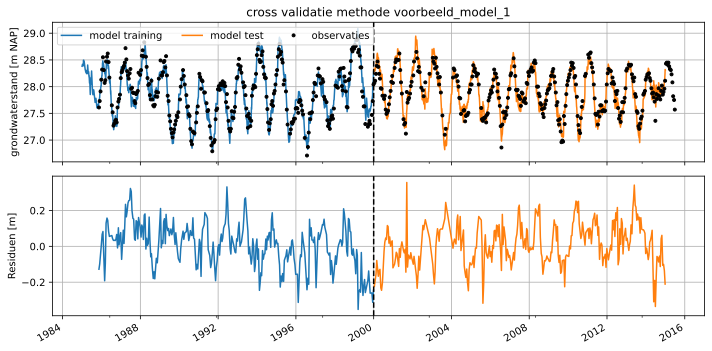

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax1.plot(ml_train1.simulate(tmin='1985', tmax='2000'), label='model training')
ax1.plot(ml_train1.simulate(tmin='2000', tmax='2015'), label='model test')
ax1.plot(ml_train1.oseries.series_original, ls='', marker='.',
         label='observaties', color='k')
ax1.legend(loc="upper left", ncol=3)
ax1.grid()
ax1.set_title('cross validatie methode voorbeeld_model_1')
ax1.set_ylabel('grondwaterstand [m NAP]')
ax1.axvline(pd.Timestamp("2000-01-01"), linestyle="dashed", 
            lw=1.5, color="k")

ml_train1.residuals(tmin='1985', tmax='2000').plot(
    ax=ax2, label="residuals train")
ml_train1.residuals(tmin='2000', tmax='2015').plot(
    ax=ax2, label="residuals test")
ax2.axvline(pd.Timestamp("2000-01-01"), linestyle="dashed", 
            lw=1.5, color="k")
ax2.set_ylabel('Residuen [m]')
ax2.grid()
fig.tight_layout()

In [11]:
df = get_stats_train_test(ml_train1,  '1985',  '2000', '2000', '2015')
# .style.set_precision(3).set_caption("Statistieken voor cross validatie voorbeeld_model_1")
df

,training: 1985-2000,test: 2000-2015,eenheid
Mean absolute error (mae),0.0967248,0.0936087,m
Root mean squared error (rmse),0.122678,0.116504,m
Sum of squares of the error (sse),4.72686,4.35255,m^2
Explained variance percentage (evp),93.4408,90.5236,%
Nash-Sutcliffe model efficiency (nse),0.934236,0.904592,-


<hr>

Als het model goed presteert in de test-periode dan is het model dat is afgeleid op basis van de trainings-periode goed genoeg om de grondwaterstanden te voorspellen in die periode. Dat geeft vertrouwen dat het model goed presteert, maar dat betekent niet per definitie dat het model ook in de toekomst goede voorspellingen zal geven. Als er in de toekomst iets structureel veranderd in het systeem (b.v. een onttrekking die start met pompen buiten beide geselecteerde periodes), dan zal het model dat uiteraard niet goed voorspellen. De hierboven besproken [fit statistieken](#Fit-statistieken) kunnen ook gebruikt worden om de voorspelling in de testperiode te toetsen. In dit geval is in plaats van de $R^2$ de $\text{NSE}$ toegepast omdat het om een voorspelling met het model gaat. Voor een uitgebreide analyse van een set aan tijdreeksmodellen met deze methode, inclusief een beschouwing van bijbehorende fit-statistieken, zie [Knotters (2012)](#Referenties).

<hr>

Als het model een goede fit heeft in de trainings-periode maar niet in de test-periode, dan is het model geen goede voorspeller van de grondwaterstand. Dit kan verschillende oorzaken hebbben. Oorzaken zijn bijvoorbeeld veranderingen in het systeem die tijdens de test-periode hebben plaatsgevonden zoals de start van een nieuwe onttrekking of het dempen van een watergang, of het meenemen van een invloed in het model die tijdens de trainingsperiode nog niet actief was, of overfitten.

<hr>

#### Voorbeeld cross-validatie 2

<br>
<p style="color:red">%% RC: beter voorbeeld, b.v. met lineaire trend in residuen? %%</p>

Hieronder een voorbeeld van een model met een goede fit in de trainingsperiode en een slechte fit in de testperiode. De slechte fit wordt veroorzaakt door een sprong in de grondwaterstanden in 2007. Deze sprong is veroorzaakt door een externe invloed die niet is meegenomen bij het trainen van het model. Het zal daarom niet mogelijk zijn om met het model een goede fit te krijgen voor de testperiode.

In [12]:
ml_cross_validatie = ps.io.load('data/vb_cross_validatie2.pas')
ml_cross_validatie.solve(tmin='1990', tmax='2002', report=False)

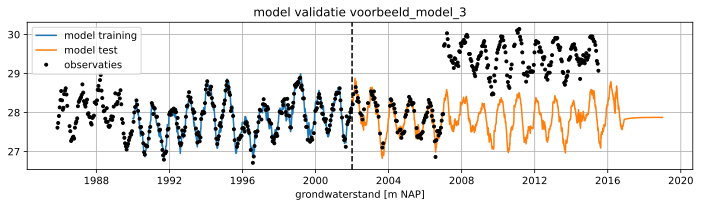

In [13]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(ml_cross_validatie.simulate(
    tmin='1990', tmax='2002'), label='model training')
ax.plot(ml_cross_validatie.simulate(
    tmin='2002', tmax='2019'), label='model test')
ax.plot(ml_cross_validatie.oseries.series_original, ls='',
        marker='.', label='observaties', color='k')
ax.axvline(pd.Timestamp("2002-01-01"), linestyle="dashed", 
            lw=1.5, color="k")
ax.legend()
ax.grid()
ax.set_title('model validatie voorbeeld_model_3')
ax.set_xlabel('grondwaterstand [m NAP]')


fig.tight_layout()

In [14]:
df = get_stats_train_test(ml_cross_validatie,  '1990',  '2003', '2003', '2019')
# df.style.set_precision(3).set_caption("Statistieken voor cross validatie voorbeeld_model_3")
df

,training: 1990-2003,test: 2003-2019,eenheid
Mean absolute error (mae),0.0914774,1.1322,m
Root mean squared error (rmse),0.115319,1.31544,m
Sum of squares of the error (sse),3.63713,474.127,m^2
Explained variance percentage (evp),93.9944,23.0614,%
Nash-Sutcliffe model efficiency (nse),0.939873,-1.69616,-


<hr>

## Modelonzekerheid

Elk tijdreeksmodel kent een bepaalde onzekerheid.  Deze onzekerheid kan opgesplitst kan worden in onzekerheid over de modelstructuur en onzekerheid in de modelparameters. In dit notebook wordt alleen de onzekerheid van de modelparameters besproken, maar er is een relatie tussen deze twee vormen van modelonzekerheid. Een grote onzekerheid in de parameters kan duiden op een suboptimale modelstructuur, en andersom zal een suboptimale modelstructuur zich vaak ook uitten in een grotere onzekerheid in de modelparameters. Voor een toelichting op de modelstructuur van tijdreeksmodellen wordt verwezen naar het [Notebook Modelstructuur](#%%). 

In tijdreeksmodellering volgens de PIRFICT methode worden externe invloeden worden gemodelleerd met responsfuncties die ieder één of meerdere parameters bevatten [(Asmuth, 2002)](#Referenties). Daarnaast kunnen in tijdreeksmodellen ook nog een constante en een ruismodel worden toegevoegd. Tijdreeksmodellen kunnen beoordeeld worden aan de hand van de berekende onzekerheden van deze modelparameters. Het is goed voor te stellen dat een model waarvan de parameters lastig te bepalen zijn (de parameters zijn onzeker) minder betrouwbaar is dan een model waarbij de parameters goed vast te stellen zijn (met een kleine onzekerheid).

Voor het beschouwen van de onzekerheden van de parameters moet de modelruis (de ruis is het resultaat van het toepassen van een ruismodel op de residuen) voldoen aan bepaalde statistische voorwaarden. Vaak wordt een ruismodel toegepast om ervoor te zorgen dat het model aan deze statistische eisen voldoet. De voorwaarden voor de ruis zijn dat het:

- zich gedraagt als witte ruis met een gemiddelde van nul. Er is sprake van witte ruis als:
  - er geen significante autocorrelatie in de ruis aanwezig is
  - de ruis homoscedastisch is
  - de ruis voldoet aan een, bij voorkeur, normale statistische verdeling.
- niet gecorreleerd is aan een verklarende tijdreeks.

Er wordt in dit notebook geen uitgebreide uitleg gegeven over deze voorwaarden, zie daarvoor de [Notebook Modelkalibratie](#%%). Er wordt wel gepresenteerd hoe deze voorwaarden visueel beoordeeld kunnen worden. Naast een visuele beoordeling bestaan er verschillende diagnostische toetsen die statistisch beoordelen of wordt voldaan aan deze voorwaarden. Het voordeel van deze toetsen is dat ze meer objectief zijn dan een visuele controle. Het nadeel is dat ze in veel gevallen alleen werken voor equidistante tijdstappen, en dus formeel niet toegepast mogen worden op reeksen met een variabele tijdstap. Zie bijvoorbeeld [deze notebook op de Pastas website](https://pastas.readthedocs.io/en/latest/examples/003_diagnostic_checking.ipynb.html) voor implementatie en een uitgebreidere beschrijving van dergelijke diagnostische toetsen [(Collenteur et al., 2019)](#Referenties).

Samenvattend mogen de berekende onzekerheden van de parameters gebruikt worden in verdere analyse als voldaan wordt aan de hierboven genoemde statistische voorwaarden.

<hr>

#### Voorbeeld betrouwbaarheid modelparameters

De standaardafwkijking van de modelparameters is berekend voor het voorbeeld model en weergegeven in onderstaande tabel. De standaardafwijking van de geschatte parameters is relatief klein ten opzichte van de absolute waarde van de parameters. Het lijkt er dus op dat de parameters relatief nauwkeurig ingeschat kunnen worden in de optimalisatie. Maar we weten nog niet of we deze berekende standaardafwijking (of onzekerheid) kunnen vertrouwen, omdat we nog niet hebben beschouwd of het model doet aan de hierboven genoemde statistische voorwaarden. 

In [15]:
params = ml1.parameters.loc[:, ["optimal", "stderr"]]
stderr = ml1.parameters.loc[:, "stderr"] / ml1.parameters.loc[:, "optimal"]
params["stderr (%)"] = stderr.abs().apply("\u00B1{:.2%}".format)
params.columns = ["optimale waarde",
                  "standaardafwijking", "standaarafwijking (%)"]
params.index.name = "parameter"
params

,optimale waarde,standaardafwijking,standaarafwijking (%)
parameter,,,
recharge_A,686.247379,36.404207,±5.30%
recharge_a,159.386066,7.990858,±5.01%
recharge_f,-1.305352,0.052736,±4.04%
constant_d,27.920125,0.058681,±0.21%
noise_alpha,49.911881,5.918768,±11.86%


De berekende onzekerheid in de parameters kan gebruikt worden om een een betrouwbaarheidsinterval te berekenen. Dit interval zegt iets over de mogelijke model uitkomsten gegeven de onzekerheid in de parameters. Dit interval wordt bijvoorbeeld berekend door $N$ trekkingen te doen uit de berekende parameter-verdelingen en daarmee de stijghoogte met het model te simuleren. Het betrouwbaarheidsinterval wordt op basis van die $N$ simulaties voor een bepaald niveau ($\alpha$) berekend (bijvoorbeeld $\alpha=0.05$, het 95%-betrouwbaarheidsinterval.
) 

In onderstaande figuur is in de rechter grafiek het 95%-betrouwbaarheidsinterval berekend voor de respons op grondwateraanvulling voor het voorbeeld model. In de linker grafiek is het voorspellingsinterval weergegeven met een grijze band rondom de modelsimulatie van de stijghoogte. Het voorspellingsinterval is de som van het betrouwbaarheidsinterval (de onzekerheid als gevolg van de onzekerheid in de parameters) plus de standaardafwijking van de residuen (de onzekerheid als gevolg van de modelfout).

Deze bandbreedtes kunnen dus waardevol zijn in de beoordeling van het model, of zelfs in een toepassing van het model, maar daarvoor moet de modelruis wel aan de eerder genoemde statistische voorwaarden voldoen. Dus in de volgende paragrafen wordt onderzocht of het model aan die voorwaarden voldoet.

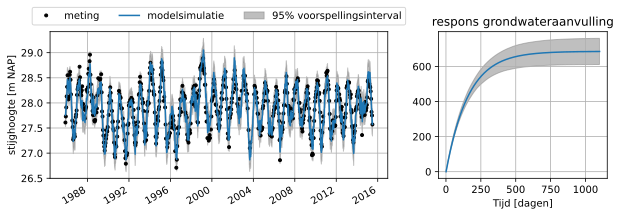

In [16]:
# Plot betrouwbaarheidsinterval
df = ml1.fit.prediction_interval()
fig = plt.figure(figsize=(10, 3))
gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0, 0])
obs = ml1.oseries.series_original
sim = ml1.simulate()

obs.plot(ax=ax1, linestyle='', marker='.', color='k', label='meting',
         x_compat=True)
sim.plot(ax=ax1, x_compat=True, label='modelsimulatie')
ax1.fill_between(df.index, df.iloc[:, 0], df.iloc[:, 1], color="gray",
                 zorder=-1, alpha=0.5, label="95% voorspellingsinterval")
ax1.set_ylabel('stijghoogte [m NAP]')
ax1.grid()
ax1.legend(bbox_to_anchor=(0.5, 1.20), ncol=3, loc='upper center')

# plot recharge response
ax2 = fig.add_subplot(gs[0, 1])
df = ml1.fit.ci_step_response("recharge", alpha=0.05, n=1000)
rch_response = ml1.get_step_response("recharge", add_0=True)

rch_response.plot(ax=ax2)
ax2.fill_between(df.index, df.iloc[:, 0], df.iloc[:, 1], color="gray",
                 zorder=-1, alpha=0.5, label="95% confidence")
ax2.grid()
ax2.set_xlabel("Tijd [dagen]")
ax2.set_title('respons grondwateraanvulling');

<hr>

### Voorwaarde 1: Autocorrelatie

Autocorrelatie is de correlatie van een tijdreeks met een in de tijd verschoven versie van zichzelf. De standaardafwijking van de modelparameters wordt te laag ingeschat als er nog significante autocorrelatie aanwezig is in de ruis. Deze vorm van correlatie kan worden weergegeven in een autocorrelatiediagram. Daarin is op de x-as de verschuiving in de tijd weergegeven (lag) en op de y-as de berekende correlatie.

<hr>

#### Voorbeeld autocorrelatiediagram

<br>
<p style="color:red">%% RC: ander voorbeeld, dagelijkse stappen %%</p>

De autocorrelatie is voor het voorbeeld model berekend met en zonder een ruismodel. De resultaten zijn weergegeven in onderstaande figuren. De maximale verschuiving is 365 dagen. Er is niet voor elke verschuiving een correlatie berekend omdat de tijdreeks die we beschouwen metingen om de $\pm$ 14 dagen bevat. 

De blauwe band in de grafiek geeft het 95% betrouwbaarheidsinterval weer. Als 95% van de berekende autocorrelaties binnen dit interval liggen kunnen we concluderen dat er geen significante autocorrelatie aanwezig is in de reeks. Het is duidelijk te zien dat de residuen van het model zonder ruismodel niet voldoen aan de eis voor de autocorrelatie. De berekende onzekerheden in de parameters zal dus niet goed ingeschat zijn. In het model met ruismodel zien we dat er geen significante autocorrelatie aanwezig is in de ruis. 

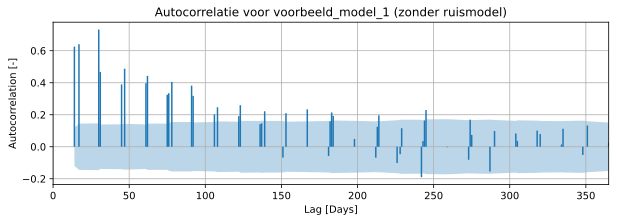

In [17]:
ml1.solve(noise=False, report=False)
ax = ps.stats.plot_acf(ml1.residuals(), figsize=(10, 3), alpha=0.05)
ax.set_title("Autocorrelatie voor voorbeeld_model_1 (zonder ruismodel)")
ylim = ax.get_ylim()
ml1.solve(noise=True, report=False);

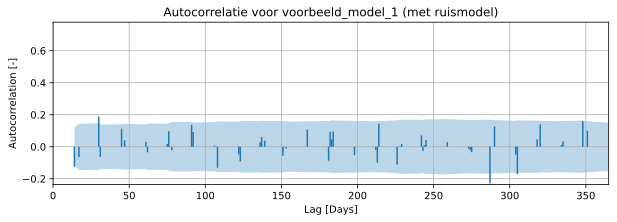

In [18]:
ax = ps.stats.plot_acf(ml1.noise(), figsize=(10, 3), alpha=0.05)
ax.set_ylim(ylim)
ax.set_title("Autocorrelatie voor voorbeeld_model_1 (met ruismodel)");

### Voorwaarde 2: Normale verdeling ruis

Een andere voorwaarde voor witte ruis is dat deze voldoet aan een, bij voorkeur, normale statistische verdeling. De verdeling van de ruis kan weergegeven worden met een histogram in combinatie met een normale kansverdeling. Visueel kan dit beoordeeld worden door een histogram te maken van de residuen/ruis en deze te vergelijken met een normale verdeling met $\mu$ gelijk aan het gemiddelde van de ruis, en $\sigma$ gelijk aan de standaardafwijking van de ruis.

<hr>

#### Voorbeeld visualisatie normale verdeling ruis

Voor het voorbeeld model is een histogram geplot van de ruis en wordt deze vergeleken met de normale verdeling. Dit is in de linker grafiek weergegeven. In de rechter grafiek is eigenlijk dezelfde analyse op een andere manier weergegeven, een zogenaamde "probability plot". Als de blauwe punten op de zwarte rechte lijn liggen is de ruis normaal verdeeld.

Op basis van deze resultaten wordt ingeschat dat de verdeling van de ruis de normale verdeling voldoende goed benaderd om het model op dit aspect goed te keuren. 

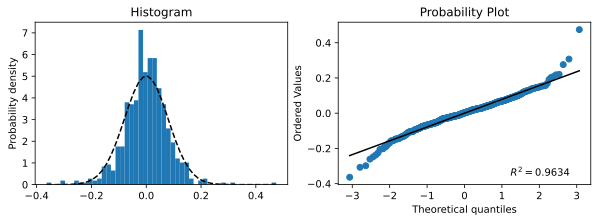

In [19]:
# Plot the histogram for normality and add a 'best fit' line
bins = 50
series = ml1.noise()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))
_, bins, _ = ax1.hist(series.values, bins=bins, density=True)
y = norm.pdf(bins, series.mean(), series.std())
ax1.plot(bins, y, 'k--')
ax1.set_ylabel("Probability density")
ax1.set_title("Histogram")

# Plot the probability plot
probplot(series, plot=ax2, dist="norm", rvalue=True)
ax2.get_lines()[0].set_color('C0')
ax2.get_lines()[1].set_color("k")

### Voorwaarde 3: Homoscedasticiteit

De derde statistische voorwaarde voor witte ruis is dat de ruis homoscedastisch moet zijn. Een tijdreeks is homoscedastisch als de variantie onafhankelijk is van de absolute waarde van de reeks. Voor een tijdreeksmodel voor het simuleren van stijghoogtes betekent dit dat de variantie van de ruis onafhankelijk is van de gemeten stijghoogtes. Als de ruis niet homoscedastisch is (oftewel heteroscedastisch) dan is de variantie van de ruis afhankelijk van de grondwaterstand. Dit kan visueel beoordeeld worden door de ruis uit te zetten tegen de stijghoogtemetingen. Als de spreiding van de ruis ongeveer gelijk is over het gehele bereik van de stijghoogtemetingen dan is de ruis homoscedastisch.

<hr>

#### Voorbeeld visualisatie homoscedasticiteit

Voor het voorbeeld model is de ruis uitgezet tegen de metingen. De spreiding in de ruis lijkt redelijk constant te zijn over het bereik van de stijghoogtemetingen. De ruis lijkt dus homoscedastisch.

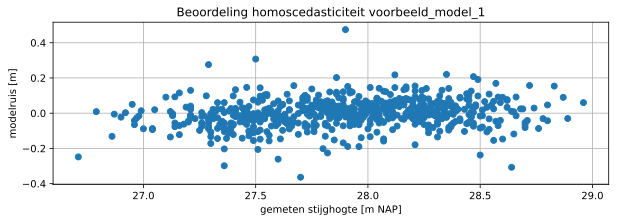

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(ml1.observations(), ml1.noise(), marker="o", linestyle=" ")
ax.set_xlabel("gemeten stijghogte [m NAP]")
ax.set_ylabel("modelruis [m]")
ax.set_title("Beoordeling homoscedasticiteit voorbeeld_model_1")
ax.grid()

### Voorwaarde 4: Correlatie ruis met verklarende tijdreeks

De laatste voorwaarde ten aanzien van de ruis is dat deze niet gecorreleerd is met een van de verklarende reeksen in het tijdreeksmodel. Als dit wel het geval is, is de gehanteerde responsfunctie blijkbaar niet in staat om het gedrag van de stijghoogte op basis van de verklarende reeks volledig te beschrijven. In dat geval kan de onzekerheid van de parameters niet nauwkeurig worden bepaald en moet de modelstructuur aangepast worden. 

## Correlatie modelparameters

Tijdens het optimaliseren van een tijdreeksmodel wordt ook de correlatie tussen de geschatte parameters berekend. Als twee parameters sterk gecorreleerd zijn betekent dit dat het effect van de parameters moeilijk van elkaar te onderscheiden is. Dit heeft meestal geen invloed op de voorspellende kracht van het tijdreeksmodel in zijn geheel, maar mogelijk wel op het inschatten van individuele bijdrages van de verklarende variabelen.

<hr>

#### Voorbeeld parameter correlaties 1

Je maakt een grondwatermodel met als verklarende reeksen recharge en oppervlaktewaterpeilen. Het model presteert goed maar de parameters van beide verklarende variabelen zijn sterk gecorreleerd. Het model is daardoor niet geschikt om de invloed van recharge en oppervlaktewater van elkaar te scheiden. Dus kan het model niet gebruikt worden om het effect van een stijging in het oppervlaktewaterpeil te berekenen. Het is immers niet duidelijk of de stijging van de grondwaterstand wordt veroorzaakt door toegenomen recharge of door een stijging van het oppervlaktewaterpeil. 

Het model kan nog wel bruikbaar zijn voor andere doeleinden. Als er bijvoorbeeld een grondwateronttrekking is gestart in de omgeving kan het effect daarvan mogelijk wel met het model bepaald worden. Voor het bepalen van dat effect is het immers niet van belang om de invloeden van recharge en oppervlaktewater van elkaar te scheiden.

<br>
<p style="color:red">%% PM: deze wegdoen en onderstaand voorbeeld proberen te vinden?%%</p>

In [21]:
# model waarbij invloed aanvulling en oppervlaktewater niet goed kunnen worden onderscheiden
# ml_river = ps.io.load("data/pastas_ex_w_river.pas")

<hr>

#### Voorbeeld parameter correlaties 2

<br>
<p style="color:red">%% PM: voorbeeld met gecorreleerde onttrekkingsreeksen %%</p>

In [22]:
# invullen model met gecorrelleerde onttrekkingen

<hr>

## Hydrologische beoordeling<a id='hydrologische beoordeling'></a>

Tijdreeksmodellen worden veel gebruikt om systeem-identificatie uit te voeren, waarbij de bijdrages van verschillende invloeden aan veranderingen in de stijghoogte worden ingeschat. Vanuit vraagstukken uit de praktijk wordt tijdreeksanalyse vaak toegepast op een heel meetnet, of op meerdere peilbuizen binnen een interessegebied. De hydrologische beoordeling van individiuele, maar ook hele sets van tijdreeksmodellen is interessant om uit te voeren. 

### Hydrologie<a id='hydrologie'></a>

Het beoordelen van modellen op basis van hydrologische aspecten kan allerlei vormen aannemen. De vragen daarbij zijn eigenlijk "werkt het systeem zoals ik denk dat het werkt" en "is wat dat ik bereken hydrologisch plausibel?". Daarbij zijn modellen die wel aan de verwachtingen voldoen net zo interessant als de modellen die daar niet aan voldoen. Denk bijvoorbeeld aan een fictief model met grondwateraanvulling en een onttrekkingsdebiet als verklarende variabelen. Een eerste eenvoudige maar belangrijke hydrologische beoordeling is de vraag of de stijghoogte ook toeneemt als het regent, en of deze daalt als er grondwater onttrokken wordt. Is dat niet het geval, dan is de kans groot dat het model niet betrouwbaar is.

Op basis van de hydrologie kunnen tijdreeksmodellen beoordeeld worden, maar andersom kunnen de modelresultaten ook het hydrologisch inzicht in het system vergroten.

<hr>

#### Voorbeeld hydrologische beoordeling

<br>
<p style="color:red">%% PM: echt voorbeeld met winning invoegen, RC: levert vb aan? %%</p>

Als voorbeeld van een hydrologische beoordeling van een tijdreeksmodel wordt de respons van een onttrekking beschouwd. In onderstaande figuur zijn twee verschillende stapresponsen weergegeven met een onzekerheidsbandbreedte. De bandbreedte van 2x de standaardafwijking is in dit geval berekend aan de hand van de onzekerheid in de gain parameter (de parameter die het stationaire effect van de onttrekking bepaald). In de linker grafiek is de onzekerheid van de staprespons klein, met andere woorden, de parameters kunnen relatief nauwkeurig bepaald worden in de optimalisatie. In de rechter grafiek is deze onzekerheid veel groter, de invloed van de onttrekking kan dus niet nauwkeurig worden ingeschat in de optimalisatie. In dit geval betekent een positieve staprespons dat de onttrekking een verlaging van de stijghoogte veroorzaakt.


![stationaire invloed met onzekerheid](data/stationaire_invloed.png)

<b><em>Stationaire invloed van een onttrekking met een kleine onzekerheid (links) en een grote onzekerheid (rechts).</em></b>
<br>

Vanuit de hydrologie moet de onttrekking voor een daling van de grondwaterstand zorgen, maar in het geval van het onzekere model (rechts) is er een een meer dan 5%-kans dat de onttrekking een verhoging van de grondwaterstand veroorzaakt. De bandbreedte is dusdanig groot dat er een kans is dat de staprespons ook negatief kan zijn. In dat geval kunnen we stellen dat dat hydrlogisch gezien niet plausibel is, en dat dit model waarschijnlijk niet goed is. De onttrekking heeft mogelijk geen significante invloed op de stijghoogte.

<hr>

### Geheugen van de respons

Een responsfunctie zegt onder andere iets over de traagheid waarmee de stijghoogte zich aanpast aan een verandering in een verklarende variabele. Een simpel voorbeeld is bijvoorbeeld hoe lang een verhoging van de stijghoogte aanhoudt na een bui. De tijd tot het effect van een verandering in een verklarende variabele op de stijghoogte verwaarloosbaar klein is wordt vaak het geheugen van de respons genoemd. 

Als het geheugen van de respons langer is dan de lengte van de tijdreeks waarop het tijdreeksmodel gekalibreerd wordt, dan is de tijdreeks eigenlijk niet voldoende lang om een dergelijke trage respons nauwkeurig in te schatten. Dus in dat geval zou het tijdreeksmodel daarop afgekeurd kunnen worden. 

Een andere manier om het geheugen van de respons te beoordelen is vanuit de hydrologie. Vanuit de hydrologische systeemkennis is het wellicht mogelijk om grenzen af te leiden ten aanzien va het geheugen van de respons, of door meerdere modellen te vergelijken kan beoordeeld worden of het geheugen van de respons plausibel is. Dit laatste voorbeeld is een vorm van ruimtelijke beoordeling, dat verder op in dit notebook nog aan bod komt. 


<hr>

#### Voorbeeld bepalen geheugen van de responsfunctie

Het geheugen van de responsfunctie kan niet bepaald worden door te kijken waar de respons gelijk is aan nul. De meeste responsfuncties zijn nooit gelijk aan nul maar benaderen nul als $t \rightarrow \infty$. Het is daarom niet mogelijk om het geheugen te bepalen door te kijken wanneer de respons nul is. Om deze reden wordt als maat voor het geheugen vaak de tijd genomen die het duurt voordat 95% van de respons is uitgewerkt. Hieronder is dit visueel weergegeven.

Geheugen (t_95) = 477 dagen


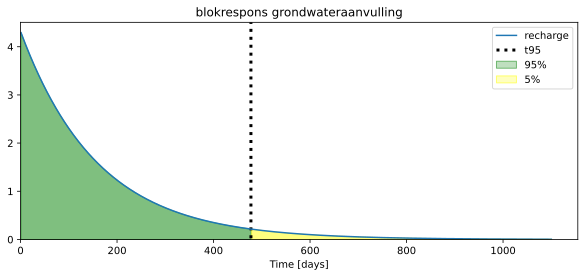

In [23]:
sm = ml1.stressmodels['recharge']
resp_func = sm.rfunc
t95 = resp_func.get_tmax(ml1.get_parameters('recharge'), cutoff=0.95)
print(f'Geheugen (t_95) = {t95:.0f} dagen')

ax = ml1.plots.block_response(figsize=(10, 4))
ylim = ax.get_ylim()
ax.vlines(t95, -100, 100, ls=':', color='k', label='t95', lw=3)

block_response = sm.rfunc.block(ml1.get_parameters('recharge'))

ax.fill_between(range(1, len(block_response)+1), 0, block_response,
                hatch='/', where=range(len(block_response)) < t95,
                alpha=0.5, color='green', label='95%')

ax.fill_between(range(1, len(block_response)+1), 0, block_response,
                where=range(len(block_response)) > t95, hatch='o',
                alpha=0.5, color='yellow', label='5%')
ax.set_ylim(0, ylim[1])
ax.legend()
ax.set_title('blokrespons grondwateraanvulling');

<hr>

#### Voorbeeld geheugen 1

Hieronder zijn van het voorbeeldmodel de blokrespons en de modelresultaten in één figuur geplot. Bij dit model is de lengte van het tijdreeksmodel een aantal maal groter dan het geheugen van de responsfunctie. Daarmee kunnen we  stellen dat de tijdreeks voldoende lang is om de respons te kunnen inschatten.

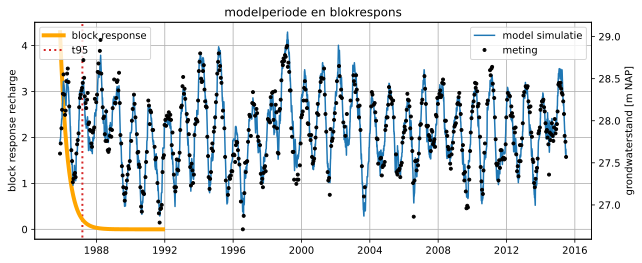

In [24]:
# get response function
sm = ml1.stressmodels['recharge']
resp_func = sm.rfunc
fig, ax = plt.subplots(figsize=(10, 4))
block_resp = resp_func.block(
    ml1.get_parameters('recharge'), cutoff=0.999999)

# plot response function
ax.plot(pd.date_range(ml1.settings['tmin'], periods=len(block_resp)), block_resp, label='block response',
        color='orange', lw=4)
ax.grid()
ax.set_ylabel('block response recharge')
# ax.set_ylim(0,6)
ax.set_title('modelperiode en blokrespons')

# plot t95 response functie
t95 = ml1.stressmodels['recharge'].rfunc.get_tmax(
    ml1.get_parameters('recharge'), cutoff=0.95)
t95_dt = ml1.settings['tmin'] + dt.timedelta(t95)
ylim = ax.get_ylim()
ax.vlines(t95_dt, -100, 100, ls=':', color='C3', label='t95', lw=2)
ax.set_ylim(ylim)
ax.legend(loc=2)

# plot model results
ax2 = ax.twinx()
ax2.plot(ml1.simulate(), label='model simulatie')  # , lw=0.2)
ax2.plot(ml1.oseries.series_original[:],
         marker='.', ls='', color='k', label='meting')
ax2.set_ylabel('grondwaterstand [m NAP]')
# ax2.set_ylim(28,31)
ax2.legend(loc=1);

<hr>

#### Voorbeeld geheugen 2

Voor een ander voorbeeldmodel is ook de blokrespons en de modelresultaten in één figuur geplot. Bij dit model is de lengte van het tijdreeksmodel kleiner dan het geheugen van de responsfunctie. Als de respons langer is dan de meetreeks, kan op basis van de gegevens niet ingeschat worden of de respons terecht zo lang is. In dit geval kan gesteld worden dat de tijdreeks niet voldoende lang is om een tijdreeksmodel voor af te leiden. 

In [25]:
ml_voorbeeld = ps.io.load(os.path.join('data', 'voorbeeld_geheugen.pas'))
ml_voorbeeld.solve(report=False)

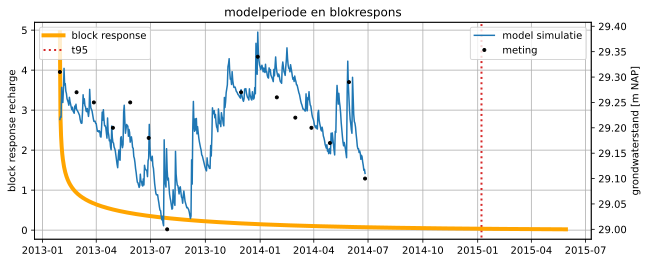

In [26]:
# get response functie
sm = ml_voorbeeld.stressmodels['recharge']
resp_func = sm.rfunc
fig, ax = plt.subplots(figsize=(10, 4))
block_resp = resp_func.block(
    ml_voorbeeld.get_parameters('recharge'), cutoff=0.97)

# plot response functie
ax.plot(pd.date_range(ml_voorbeeld.settings['tmin'], periods=len(block_resp)), block_resp,
        label='block response',
        color='orange', lw=4)
ax.grid()
ax.set_ylabel('block response recharge')
ax.set_title('modelperiode en blokrespons')

# plot t95 response functie
t95 = ml_voorbeeld.stressmodels['recharge'].rfunc.get_tmax(
    ml_voorbeeld.get_parameters('recharge'), cutoff=0.95)
t95_dt = ml_voorbeeld.settings['tmin'] + dt.timedelta(t95)
ylim = ax.get_ylim()
ax.vlines(t95_dt, -100, 100, ls=':', color='C3', label='t95', lw=2)
ax.set_ylim(ylim)

ax.legend(loc=2)

# plot model results
ax2 = ax.twinx()
ax2.plot(ml_voorbeeld.simulate(), label='model simulatie')  # , lw=0.2)
ax2.plot(ml_voorbeeld.oseries.series_original,
         marker='.', ls='', color='k', label='meting')
ax2.set_ylabel('grondwaterstand [m NAP]')
ax2.legend(loc=1);

<hr>

### Grondwateraanvulling en verdamping

<br>
<p style="color:red">%% PM: iets zeggen over de waarde van $f$?. %% </p>

<hr>

#### Voorbeeld verdampingsfactor

<br>
<p style="color:red"> %% PM: voorbeeld invoegen met verdampingsfactor %% </p>

<hr>

### Ruimtelijke beoordeling

In veel studies wordt tijdreeksanalyse toegepast op meerdere stijghoogtemeetpunten. Deze studies hebben bijvoorbeeld als doel om uit te zoeken waar de stijghoogtes goed verklaard kunnen worden aan de hand van een grondwateraanvulling, of willen graag uitzoeken wat de invloed is van een drinkwaterwinning op de stijghoogte, en zo zijn er tal van andere voorbeelden te bedenken. In dit soort studies is het nuttig om een ruimtelijke beoordeling te doen van de resultaten. Voor voorbeelden van ruimtelijke analyses, zie bijvoorbeeld [Baggelaar (1988)](#Referenties), [Asmuth (2012)](#Referenties), en [Berendrecht (2016)](#Referenties). 

Het is onmogelijk om alle mogelijke soorten ruimtelijke beoordelingen te noemen dus wordt dit aspect aan de hand van het volgende voorbeeld toegelicht.

<hr>

#### Voorbeeld hydrologische ruimtelijke beoordeling

Een voorbeeld van ruimtelijke beoordeling van tijdreeksmodellen wordt gegeven aan de hand van een voorbeeld uit [Collenteur et al. (2019)](#Referenties). In die studie zijn tijdreeksmodellen afgeleid voor peilbuizen binnen een straal van $\pm$ 5 km rondom een drinkwater winning van Brabant Water bij Seppe. In deze tijdreeksmodellen zijn neerslag, verdamping en het onttrekkingsdebiet van winning Seppe als verklarende variabelen meegenomen. Vervolgens zijn de tijdreeksmodellen geoptimaliseerd. In onderstaande figuur zijn de berekende stationaire invloeden (ook wel bekend als de 'gain') van de winning Seppe uitgezet tegen de afstand tussen de peilbuizen en het de winlocatie. Daarbij is onderscheid gemaakt tussen peilbuizen in het eerste en tweede watervoerende pakket. De verticale balken geven de onzekerheid aan, en komen overeen met 2 maal de standaardafwijking van de parameter. De stationaire invloed is berekend voor een onttrekkingsdebiet van 1 miljoen m$^3$/jaar. In de figuur is ook de stationaire invloed van de onttrekking als functie van de afstand opgenomen. Deze is berekend met een 2-laags analytisch elementen grondwatermodel [(Bakker et al., 2003)](#Referenties) en dient als extra controle op de geschatte invloed volgens de tijdreeksmodellen.

<br>

![Berekende stationaire invloed winning Seppe als functie van de afstand bij onttrekking van 1 Mm^3/jaar](data/drawdown_screenshot.png)

<b><em>Berekende stationaire invloed winning Seppe als functie van de afstand bij een onttrekkingsdebiet van 1 Mm$^3$/jaar (bron: Collenteur et al. (2019))</em></b>

<br>


Elk tijdreeksmodel is onafhankelijk ten opzichte van de andere modellen; er wordt per model op basis van de gemeten stijghoogtes ingeschat wat de bijdrages van neerslag, verdamping en onttrekking zijn op de verandering in de grondwaterstand. Het berekende patroon van een grotere verlaging nabij de winning past goed op de theoretische invloed van een onttrekking. Ook het verschil tussen het eerste en tweede watervoerende pakket is duidelijk op te maken uit de resultaten van de tijdreeksmodellen. De resultaten komen ook aardig overeen met een berekening met een eenvoudig grondwatermodel.

Deze onafhankelijke modellen lijken goed in staat om de invloed van de drinkwaterwinning op de stijhgoogtes in te schatten, dus op basis van deze ruimtelijke beoordeling wordt geconcludeerd dat de tijdreeksmodellen toegepast kunnen worden verdere analyses te doen over de invloed van de winning op de stijghoogtes. Een ruimtelijke hydrologische beschouwing van de resultaten van meerdere tijdreeksmodellen kan dus waardevol zijn in de beoordeling van die tijdreeksmodellen. 

<hr>

## Discussie

<br>
<p style="color:red"> %% PM: wat komt hier? %% </p>

## Referenties

<br>
<p style="color:red"> %% PM: invullen referenties %% </p>

- Baggelaar, P.K. 1988. Tijdreeksanalyse bij verlagingsonderzoek: principe en voorbeeld. H$_2$O (21) nr. 15
- Bakker, M., and O.D.L. Strack. 2003. Analytic Elements for Multiaquifer Flow. Journal of Hydrology, 271(1-4), 119-129.
- Collenteur, R.A., M. Bakker, R. Caljé, S.A. Klop, F. Schaars. 2019. Pastas: Open Source Software for the Analysis of Groundwater Time Series. Groundwater, Vol. 57, No. 6, 877–885
- van Geer, F. (2012) Tijdreeksanalyse: Introductie en aandachtspunten. Stromingen 18, nummer 2.
- Jackson et al. (2019) Introductory overview: Error metrics for hydrological modelling - A review of common practices and an open source library to facilitate use and adoption. Environmental Modelling & Software 119, 32-48.
- Knotters, M. (2012) Validatie van tijdreeksmodellen voor de grondwaterstand. Stromingen 18, nummer 2.
- Von Asmuth, J. R., K. Maas, and M. F. P. Bierkens (2002), Transfer function-noise modeling in continuous time using predefined impulse response functions, Water Resour. Res., 38(12), 1287.
- Von Asmuth, J. R., K. Maas, M. Knotters, M. F. P. Bierkens, M. Bakker, T. N. Olsthoorn, D. G. Cirkel, I. Leunk, F. Schaars, and D. C. von Asmuth (2012), Software for hydrogeologic time series analysis, interfacing data with physical insight, Environmental Modelling & Software, 38(0), 178-190.


Nog toevoegen?

- Zaadnoordijk (TNO) voor lijst met criteria voor toetsen modellen?
- Berendrecht (2016) Ruimtelijke hydrologische analyse
- Arsenault (2018), niet cross-valideren maar kalibreren op hele set
- Konikow (1992), niet validatie, maar "model testing" en "invalidation"
- Poeter, E. & Anderson, D. (2005) Multimodel Ranking and Inference in Ground Water Modeling. Ground Water 43, 597-605